# Breast cancer detection using histopathology images

## Overview  

Breast cancer is the most common type of cancer and the second leading cause of cancer death in women. There are more than 200,000 new cases every year in US. If a patient is suspected to have breast cancer during the regular screening, small amount of cancer tissue will be taken for further examination, and pathologists will examine the each tissue samples to determine cancer. This process is critical in cancer diagnosis, thus my goal for this project is to build a model to detect breast cancer using microscope images. This model could help pathologists to expedite diagnosis process and also patients to get treatment sooner.  
  
I found my dataset from Kaggle. The dataset consists with 198,738 cancer-negative and 78,786 cancer-positive images with labels.  
https://www.kaggle.com/paultimothymooney/breast-histopathology-images


## Getting ready  
Import required packages and download data

In [1]:
# install required package
!pip install mahotas

     |████████████████████████████████| 1.5MB 3.7MB/s 
  Created wheel for mahotas: filename=mahotas-1.4.9-cp36-cp36m-linux_x86_64.whl size=4265662 sha256=5ba4cdc87362d05c68c78a261caf2c462ef135cd58658cd0debcf2cf46b8a34a
  Stored in directory: /root/.cache/pip/wheels/02/e7/50/b67eee3b19c479cc5b41f10230bf9c1556be6eaaf095c6e997
Successfully built mahotas


In [2]:
#######################
# standard code block #
#######################

# see https://ipython.readthedocs.io/en/stable/interactive/magics.html
%pylab inline

# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']

#######################
#       imports       #
#######################

import numpy as np
import pandas as pd

from numpy.random import seed
seed(42)

import os
from glob import glob
import fnmatch

import cv2
import mahotas

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

import random

Populating the interactive namespace from numpy and matplotlib


In [0]:
# connect to my google drive
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# getting reday for downloading dataset from Kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jisong316","key":"b4ce852d688c7ce105a32610305f35b6"}'}

In [4]:
# set permission for downloading dataset from Kaggle
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [5]:
# downloading dataset
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.09G/3.10G [00:50<00:03, 3.64MB/s]
100% 3.10G/3.10G [00:50<00:00, 65.5MB/s]


In [6]:
# unzip the downloaded data
!unzip "/content/breast-histopathology-images.zip"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2301_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2351_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/

## Exploring the data structure

In [0]:
# creating a list of patients ids from folder/file names
patients=os.listdir('/content/IDC_regular_ps50_idx5')

In [8]:
# number of patients?
len(patients)

279

In [0]:
!mkdir data
image_path="/content/data/"

In [0]:
# move all images to the same folder

# create a list of all patient id's
for patient in patients:
    
    path_0 = '/content/IDC_regular_ps50_idx5/' + str(patient) + '/0'
    path_1 = '/content/IDC_regular_ps50_idx5/' + str(patient) + '/1'


    # create a list of all files in folder 0
    file_list_0 = os.listdir(path_0)
    # create a list of list all file in folder 1
    file_list_1 = os.listdir(path_1)

    # move the 0 images to all_images_dir
    for fname in file_list_0:

        # source path to image
        src = os.path.join(path_0, fname)
        # destination path to image
        dst = os.path.join(image_path, fname)
        # copy the image from the source to the destination
        shutil.move(src, dst)


    # move the 1 images to data
    for fname in file_list_1:

        # source path to image
        src = os.path.join(path_1, fname)
        # destination path to image
        dst = os.path.join(image_path, fname)
        # copy the image from the source to the destination
        shutil.move(src, dst)

In [11]:
# number of images?
len(os.listdir('data'))

277524

In [0]:
!rm -rf IDC_regular_ps50_idx5/

In [13]:
# make a list of images
image_list = os.listdir('data')

df = pd.DataFrame(image_list, columns=['image_id'])

df.head()

,image_id
0,15634_idx5_x851_y1501_class1.png
1,9077_idx5_x1551_y501_class1.png
2,12749_idx5_x2201_y851_class1.png
3,9291_idx5_x1351_y1201_class0.png
4,12955_idx5_x1151_y2401_class0.png


In [0]:
# extracting patient ids from the image list
df['patient_id'] = df['image_id'].str.split('_').str[0]

# extracting target values
df['target'] = df['image_id'].str[-5]

In [0]:
df['x'] = df['image_id'].str.split('_').str[2]
df['y'] = df['image_id'].str.split('_').str[3]
df['x'] = df['x'].str.replace(r'x', '')
df['y'] = df['y'].str.replace(r'y', '')

In [16]:
df.head()

,image_id,patient_id,target,x,y
0,15634_idx5_x851_y1501_class1.png,15634,1,851,1501
1,9077_idx5_x1551_y501_class1.png,9077,1,1551,501
2,12749_idx5_x2201_y851_class1.png,12749,1,2201,851
3,9291_idx5_x1351_y1201_class0.png,9291,0,1351,1201
4,12955_idx5_x1151_y2401_class0.png,12955,0,1151,2401


In [0]:
# save the dataframe for later use
df.to_csv('/content/drive/My Drive/cancer/df.csv')

In [0]:
# function to draw random images

def draw_patch(col_name,figure_cols, df, path):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=path + sample.iloc[j]['image_id']
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

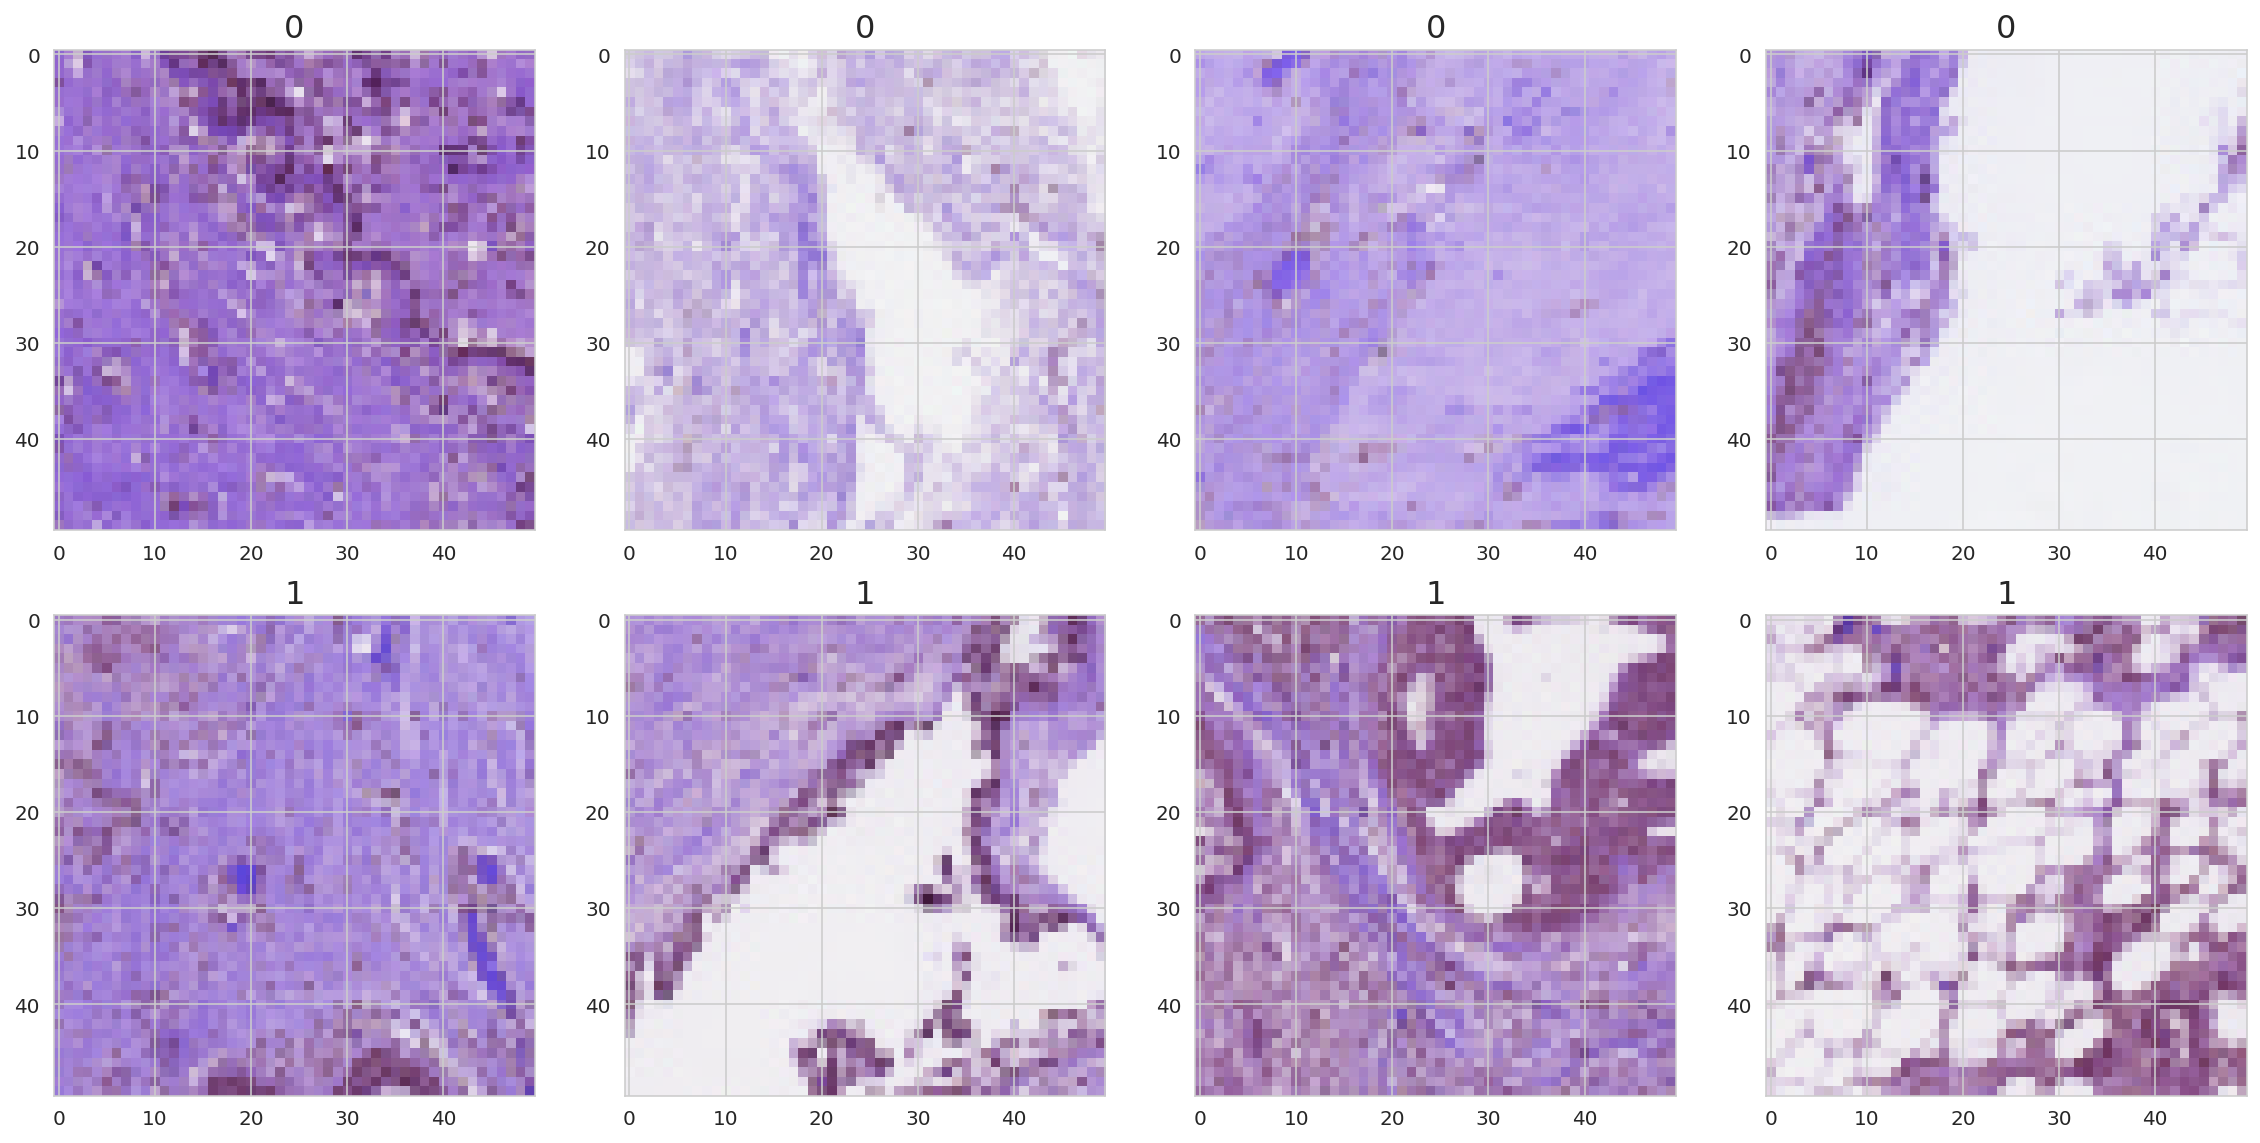

In [18]:
image_path = 'data/'

draw_patch('target',4, df, image_path)

0    198738
1     78786
Name: target, dtype: int64
Percentage of Majority Class: 71.611


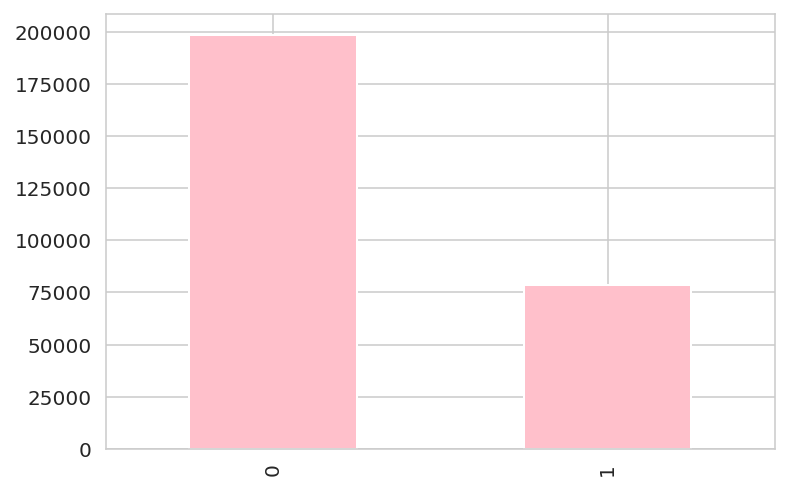

In [0]:
# check the target balance
print(df['target'].value_counts())
print('Percentage of Majority Class:', 
      round(df['target'].value_counts()[0]/sum(df['target'].value_counts())*100, 3))

fig=df['target'].value_counts().plot(kind='bar', color='pink')
# plt.savefig('/content/drive/My Drive/cancer/target_distribution.svg')

## Data preprocessing

In [0]:
# random undersampling to balnce the target

# take a sample of the majority class 0 (total = 198738)
df_0 = df[df['target'] == '0'].sample(df['target'].value_counts()[1], random_state=42)
# take a sample of class 1 (total = 78786)
df_1 = df[df['target'] == '1']

# concat the two dataframes
df_bal = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

# Check the new class distribution
df_bal['target'].value_counts()


0    78786
1    78786
Name: target, dtype: int64

In [0]:
# save the dataframe for later use
df_bal.to_csv('/content/drive/My Drive/cancer/df_bal.csv')

In [0]:
y = df_bal['target']

df_train_val, df_test = train_test_split(df_bal, test_size=0.2, random_state=42, stratify=y)

print(df_train_val.shape)
print(df_test.shape)

(126057, 5)
(31515, 5)


In [0]:
y_train_val = df_train_val['target']
df_train, df_val = train_test_split(df_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

print(df_train.shape)
print(df_val.shape)

(100845, 5)
(25212, 5)


In [0]:
# save the dataframe for later use
df_train.to_csv('/content/drive/My Drive/cancer/df_train.csv')
df_val.to_csv('/content/drive/My Drive/cancer/df_val.csv')
df_test.to_csv('/content/drive/My Drive/cancer/df_test.csv')

In [0]:
# make directory to store train, val, test set images
!mkdir train
!mkdir train/negative
!mkdir train/positive
!mkdir val
!mkdir val/negative
!mkdir val/positive
!mkdir test
!mkdir test/negative
!mkdir test/positive

In [0]:
# Set the id as the index
df_bal.set_index('image_id', inplace=True)

In [0]:
# Get a list of train, val, test images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])
test_list = list(df_test['image_id'])

In [0]:
train_path='/content/train'
val_path='/content/val'
test_path='/content/test'

In [0]:
df.set_index('image_id', inplace=True)

In [0]:
for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image
    # get the label for a certain image
    target = df.loc[image,'target']
    
    # these must match the folder names
    if target == '0':
        label = 'negative'
    if target == '1':
        label = 'positive'
    
    # source path to image
    src = os.path.join(image_path, fname)
    # destination path to image
    dst = os.path.join(train_path, label, fname)
    # move the image from the source to the destination
    shutil.copyfile(src, dst)

In [0]:
for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image
    # get the label for a certain image
    target = df.loc[image,'target']
    
    # these must match the folder names
    if target == '0':
        label = 'negative'
    if target == '1':
        label = 'positive'
    
    # source path to image
    src = os.path.join(image_path, fname)
    # destination path to image
    dst = os.path.join(val_path, label, fname)
    # move the image from the source to the destination
    shutil.copyfile(src, dst)

In [0]:
for image in test_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image
    # get the label for a certain image
    target = df.loc[image,'target']
    
    # these must match the folder names
    if target == '0':
        label = 'negative'
    if target == '1':
        label = 'positive'
    
    # source path to image
    src = os.path.join(image_path, fname)
    # destination path to image
    dst = os.path.join(test_path, label, fname)
    # move the image from the source to the destination
    shutil.copyfile(src, dst)

In [0]:
train_images = glob('/content/train/*/*.png', recursive=True)
val_images = glob('/content/val/*/*.png', recursive=True)
test_images = glob('/content/test/*/*.png', recursive=True)

In [0]:
# function to process the images
def proc_images(image_list,lowerIndex,upperIndex):
    """
    Takes list of images and returns two arrays: 
        x is an array of resized images
        y is a label
    """ 
    x = []
    y = []
    
    pattern_0 = '*class0.png'
    pattern_1 = '*class1.png'
    
    negative = fnmatch.filter(image_list, pattern_0)
    positive = fnmatch.filter(image_list, pattern_1)

    for img in image_list[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        img1=cv2.resize(full_size_image,(50,50))

        img2=cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

        humoments=cv2.HuMoments(cv2.moments(img2)).flatten()
        haralick=mahotas.features.haralick(img2).mean(axis=0).flatten()

        img3=cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)

        hist=cv2.calcHist([img3],[0,1,2],None,[8,8,8],[0,256,0,256,0,256]).flatten()
        histogram=cv2.normalize(hist, hist)
        
        features=np.hstack([histogram,haralick,humoments])
        
        x.append(features)

        if img in negative:
            y.append(0)
        elif img in positive:
            y.append(1)
        else:
            return
    return x,y

In [0]:
X_train,y_train = proc_images(train_images,0,100845)

In [0]:
df_train1 = pd.DataFrame(X_train)

In [0]:
df_train1['labels']=y_train
df_train1

In [0]:
# save training dataframe for later use
df_train1.to_csv('/content/drive/My Drive/cancer/df_train_t.csv')

In [0]:
np.save('/content/drive/My Drive/cancer/X_train', X_train)

In [0]:
np.save('/content/drive/My Drive/cancer/y_train', y_train)

In [0]:
X_val,y_val = proc_images(val_images,0,25212)

In [0]:
len(np.ravel(X_val))/25212

532.0

In [0]:
df_val1 = pd.DataFrame(X_val)
df_val1['labels']=y_val
df_val1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,labels
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002948,1057.875444,0.768354,2282.866749,0.149281,369.360746,8073.591551,7.430028,10.598793,0.000125,5.719589,-0.368800,0.995827,0.000920,3.498503e-09,1.375543e-12,1.035535e-12,-1.361219e-25,-5.309170e-17,-1.228383e-24,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.296920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003075,319.315968,0.805195,820.765876,0.177487,427.540342,2963.747534,6.896688,10.197339,0.000191,4.940048,-0.292930,0.984438,0.000763,1.150187e-09,4.707886e-13,6.510481e-15,2.579889e-28,3.422130e-20,2.517111e-28,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000693,518.031100,0.279572,359.746473,0.079761,274.096764,920.954792,6.727970,10.927277,0.000112,5.474324,-0.190531,0.948521,0.001209,3.833195e-10,5.035401e-13,3.909244e-13,-1.117807e-25,2.238624e-19,1.326178e-25,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013823,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000518,715.808290,0.569255,830.756244,0.087268,300.303663,2607.216688,7.224968,11.277241,0.000100,5.628588,-0.264426,0.983728,0.001109,1.974060e-09,9.855378e-14,3.744699e-12,-2.227562e-24,1.434442e-16,4.616585e-25,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000513,1757.157645,0.591438,2149.946149,0.073071,310.657341,6842.626949,7.988962,11.635253,0.000062,6.242055,-0.367199,0.997310,0.001074,2.922814e-10,1.485503e-12,5.787529e-12,2.947875e-24,-6.452390e-17,1.671179e-23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002008,1281.555046,0.747671,2538.742013,0.132919,373.427187,8873.413007,7.617545,10.784082,0.000108,5.865224,-0.358021,0.995420,0.000880,5.887650e-10,8.830727e-14,2.329225e-12,-1.043205e-24,1.550320e-17,-1.662448e-25,1
25208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000338,961.253667,0.571376,1121.357360,0.058565,325.624971,3524.175774,7.718274,11.734855,0.000068,5.943596,-0.316023,0.993859,0.001014,1.850750e-09,2.099246e-12,3.142847e-12,-5.649588e-24,1.289569e-16,5.766279e-24,1
25209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.339548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [0]:
# save validation dataframe for later use
df_val1.to_csv('/content/drive/My Drive/cancer/df_val_t.csv')

In [0]:
np.save('/content/drive/My Drive/cancer/X_val', X_val)

In [0]:
np.save('/content/drive/My Drive/cancer/y_val', y_val)

In [0]:
X_test,y_test = proc_images(test_images,0,31515)

In [0]:
len(np.ravel(X_test))/31515

532.0

In [0]:
df_test1 = pd.DataFrame(X_test)
df_test1['labels']=y_test
df_test1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,labels
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.051680,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.001202,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000407,2020.311424,0.469488,1903.741218,0.059630,338.017826,5594.653446,7.944046,11.747746,0.000045,6.443877,-0.346754,0.996361,0.000988,2.896472e-11,5.173964e-13,3.716285e-13,-8.973963e-26,-6.283619e-19,1.360222e-25,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.325435,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008762,706.160594,0.699871,1175.947035,0.231432,443.255575,3997.627547,6.445757,9.245944,0.000245,5.098444,-0.290993,0.977629,0.000741,7.915271e-10,2.207418e-12,5.271304e-14,1.627217e-26,2.739347e-19,-7.651214e-27,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.094324,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.001003,0.0,0.001003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001087,562.430962,0.648777,800.805356,0.119493,392.147164,2640.790461,7.225813,11.034103,0.000123,5.403355,-0.283938,0.986910,0.000856,1.765626e-10,2.166368e-14,1.863467e-13,1.088137e-26,1.991093e-18,-4.666845e-27,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.208369,0.0,0.0,0.0,0.0,0.0,0.0,0.000969,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012183,829.708034,0.674252,1274.202949,0.311430,436.793186,4267.103760,6.631158,9.123760,0.000342,4.883699,-0.396776,0.994466,0.000757,1.605706e-09,4.892714e-14,6.879591e-14,-1.762767e-27,2.696382e-18,3.580985e-27,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.014524,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000523,433.306797,0.698261,719.148946,0.090468,350.388251,2443.288985,7.325996,11.247146,0.000120,5.311726,-0.274885,0.985730,0.000951,5.932506e-11,8.359692e-13,3.375276e-13,-7.970136e-27,8.659484e-19,1.791140e-25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31510,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.127636,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004638,1307.042468,0.628169,1757.513063,0.185530,428.918207,5723.009784,6.882061,9.752855,0.000182,5.519362,-0.311140,0.985880,0.000769,1.260380e-10,2.539945e-13,6.424878e-14,4.763720e-27,-3.302343e-19,-6.683531e-27,1
31511,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000644,454.272828,0.190206,280.467788,0.068810,314.493032,667.598323,6.595091,10.960563,0.000109,5.395286,-0.171127,0.933336,0.001060,4.915674e-11,4.512379e-14,6.08746

In [0]:
# save test dataframe for later use
df_test1.to_csv('/content/drive/My Drive/cancer/df_test_t.csv')

In [0]:
np.save('/content/drive/My Drive/cancer/X_test', X_test)

In [0]:
np.save('/content/drive/My Drive/cancer/y_test', y_test)